In [1]:
import numpy as np
from scipy.optimize import minimize
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [2]:
def sum_of_powers(G, n):
    """
    Compute the sum of powers of a matrix G up to the n-th power: G + G^2 + ... + G^n.
    
    Parameters:
    - G: numpy array, the matrix G.
    - n: int, the highest power to include in the sum.
    
    Returns:
    - sum_powers: numpy array, the sum of powers of G from 1 to n.
    """
    sum_powers = np.zeros_like(G)  # Initialize the sum as a zero matrix of the same shape as G
    current_power = np.copy(G)  # The current power of G, starting with G itself
    
    for i in range(1, n + 1):
        sum_powers += current_power  # Add the current power to the sum
        current_power = np.dot(current_power, G)  # Compute the next power of G
        
    return sum_powers

# Agent Utilitiy

In [63]:
def agent_utility(q, x, G, i):
    """
    Calculate the quadratic utility for agent i.
    
    Parameters:
    - q (numpy array): The linear coefficients for each agent.
    - x (numpy array): The choices or quantities selected by each agent.
    - g (numpy matrix or 2D array): The interaction coefficients between agents.
    - i (int): The index of the agent for whom to calculate the utility.
    
    Returns:
    - float: The calculated utility for agent i.
    """
    # Linear term for agent i
    linear_term = q[i] * x[i]
    
    # Quadratic term for agent i
    quadratic_term = -0.5 * x[i]**2
    
    # Interaction term for agent i with all other agents j
    interaction_term = -np.sum([G[i, j] * x[i] * x[j] for j in range(len(x))])
    
    # Total utility for agent i
    utility_i = linear_term + quadratic_term + interaction_term
    
    return utility_i


# Example usage
q = np.array([1, 2, 3])  # Linear coefficients for agents
# x = np.array([0.5, 1.5, 2.5])  # Choices of agents
x = np.array([random.uniform(0, 3) for i in range(3)])
print(x)
g = np.array([[0, 0.1, 0.2],  # Interaction coefficients between agents
              [0.1, 0, 0.3],
              [0.2, 0.3, 0]])
# i = 0  # Agent index for whom we're calculating the utility

for i in range(3):
    utility_i = agent_utility(q, x, g, i)
    print(f"The calculated utility for agent {i} is: {utility_i}")

[2.09917836 0.11454432 1.28196824]
The calculated utility for agent 0 is: -0.6663574325575934
The calculated utility for agent 1 is: 0.1544308850575199
The calculated utility for agent 2 is: 2.441914788043676


# Socially Optimal Solution

In [213]:
def total_utility(x, q, g):
    """
    Calculate the total utility for all agents by summing individual utilities.
    """
    return sum(agent_utility(q, x, g, i) for i in range(len(q)))


def optimize_each_agent(q, g, x, i, bounds_i):
    """
    Optimize the choice for agent i, given current choices of other agents.
    """
    def objective(x_i):
        x_new = np.copy(x)
        x_new[i] = x_i
        return -total_utility(x_new, q, g)

    result = minimize(objective, x[i], bounds=[bounds_i])
    if result.x < 0:
        return 0
    else:
        return result.x


def find_social_optimum(q, g, bounds):
    """
    Find the socially optimal solution that maximizes the total utility.
    """
    num_agents = len(q)
    x0 = np.ones(num_agents)  # Initial guess for the optimization
    
    # Minimize the negative of the total utility to find the maximum total utility
    objective = lambda x: -total_utility(x, q, g)
    opt_result = minimize(objective, x0, bounds=bounds)

    return opt_result

n = 10
q = np.random.rand(n)  # Random linear coefficients for agents
g = (np.random.rand(n, n)-0.5)*2  # Random interaction coefficients between agents
bounds = [(0, None)] * n  # Assume non-negative choices

opt_result = find_social_optimum(q, g, bounds)
print(f"Socially optimal solution: {opt_result.x}")
print(f"Maximum total utility: {-opt_result.fun}")
# totla utility for x
# x = np.array([random.uniform(0, 3) for i in range(n)])
# print(f"Total utility for x = {x}: {total_utility(x, q, g)}")


Socially optimal solution: [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 1.98283189e+149 1.82565403e+145 1.94758445e+149
 0.00000000e+000 7.47058075e+149]
Maximum total utility: nan


/var/folders/hs/y116vr4j4yg5fcthw_l99c5r0000gn/T/ipykernel_24647/1821943446.py:18: RuntimeWarning: overflow encountered in double_scalars
  quadratic_term = -0.5 * x[i]**2
/var/folders/hs/y116vr4j4yg5fcthw_l99c5r0000gn/T/ipykernel_24647/1821943446.py:21: RuntimeWarning: overflow encountered in double_scalars
  interaction_term = -np.sum([G[i, j] * x[i] * x[j] for j in range(len(x))])
/var/folders/hs/y116vr4j4yg5fcthw_l99c5r0000gn/T/ipykernel_24647/1821943446.py:24: RuntimeWarning: invalid value encountered in double_scalars
  utility_i = linear_term + quadratic_term + interaction_term
/var/folders/hs/y116vr4j4yg5fcthw_l99c5r0000gn/T/ipykernel_24647/4042438181.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return sum(agent_utility(q, x, g, i) for i in range(len(q)))
/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/mac

In [205]:
a = np.dot(np.linalg.inv(np.eye(n)-2*g), q)
print(a)

[ 1.75124164  0.26117435  2.1185699  -0.60565846  0.60565234  0.3522856
  0.80030786 -1.78921455 -0.68138484  0.64638868]


# Individual Maximization

In [171]:
def optimize_agent_i(q, g, x, i, bounds_i):
    """
    Optimize the choice for agent i, given current choices of other agents.
    """
    def objective_i(x_i):
        x_new = np.copy(x)
        x_new[i] = x_i
        return -agent_utility(q, x_new, g, i)

    result = minimize(objective_i, x[i], bounds=[bounds_i])
    if result.x < 0:
        return 0
    else:
        return result.x


def maximize_individual_utilities_iteratively(q, g, initial_x, bounds, tol=1e-2, max_iter=100):
    """
    Iteratively maximize each agent's utility until convergence.
    """
    x = np.copy(initial_x)
    for iteration in range(max_iter):
        x_new = np.copy(x)
        for i in range(len(q)):
            x_new[i] = optimize_agent_i(q, g, x, i, bounds[i])

        # Check for convergence
        if np.linalg.norm(x_new - x) < tol:
            print(f"Convergence achieved after {iteration + 1} iterations.")
            break
        x = x_new
    # else:
        # print("Max iterations reached without convergence.")

    return x

# Example usage
q = np.array([1, 2, 3])  # Linear coefficients for agents
g = np.array([[0, 0.1, 0.2],  # Interaction coefficients between agents
              [0.1, 0, 0.3],
              [0.2, 0.3, 0]])
initial_x = np.array([0.5, 1, 1.5])  # Initial guesses for choices
bounds = [(0, None), (0, None), (0, None)]  # Assume non-negative choices

for i in range(1, 5):
    optimized_x = maximize_individual_utilities_iteratively(q, sum_of_powers(g, i), initial_x, bounds)
    print(f"Optimized choices for each agent after {i} hop(s): {optimized_x}")
    print(f"Total utility at the end: {total_utility(optimized_x, q, sum_of_powers(g, i))}")

Convergence achieved after 7 iterations.
Optimized choices for each agent after 1 hop(s): [0.36548402 1.19096002 2.56582793]
Total utility at the end: 4.081527100159692
Convergence achieved after 6 iterations.
Optimized choices for each agent after 2 hop(s): [0.3260189  1.07951729 2.04973683]
Total utility at the end: 3.393532579209766
Convergence achieved after 6 iterations.
Optimized choices for each agent after 3 hop(s): [0.27780663 1.00660003 1.99943782]
Total utility at the end: 3.2182075582201652
Convergence achieved after 5 iterations.
Optimized choices for each agent after 4 hop(s): [0.26527747 0.9845704  1.93694833]
Total utility at the end: 3.148524212128456


# Function for creating different types of networks

In [200]:
n = 10
bounds = [(0, None)] * n

# # function to create PD matrix
# def create_PD_matrix(n):
#     A = (np.random.rand(n, n)-0.5)*2 
#     B = np.dot(A, A.T)
#     np.fill_diagonal(B, 0)
#     return B

# G2 = create_PD_matrix(n)

q = np.random.randint(1, 10, n)
G2 = np.random.rand(n, n)

In [201]:
# # plot G2 with edge weights
# G = nx.from_numpy_matrix(G2)
# pos = nx.spring_layout(G)
# edge_labels = {(i, j): f"{G2[i, j]:.2f}" for i, j in G.edges()}
# nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_weight='bold', font_size=10)
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
# plt.show()


Convergence achieved after 2 iterations.
Convergence achieved after 2 iterations.
Convergence achieved after 2 iterations.
Convergence achieved after 2 iterations.
Convergence achieved after 2 iterations.
Convergence achieved after 2 iterations.
Convergence achieved after 2 iterations.
Convergence achieved after 2 iterations.
Convergence achieved after 2 iterations.
Convergence achieved after 2 iterations.
Convergence achieved after 2 iterations.
Convergence achieved after 2 iterations.
Convergence achieved after 2 iterations.
Convergence achieved after 2 iterations.
Convergence achieved after 2 iterations.


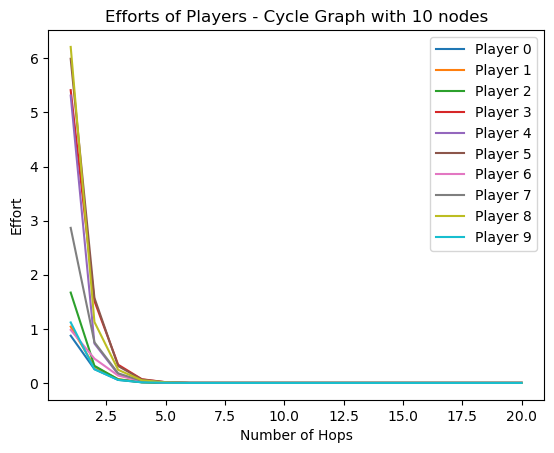

In [202]:
G = G2

soc_opt_result = find_social_optimum(q, G, bounds)

max_hops = 20

# x_init = soc_opt_result.x
x_init = np.ones(n)

x_nash_list1 = []
for hops in range(1, max_hops + 1):
    x_nash = maximize_individual_utilities_iteratively(q, sum_of_powers(G, hops), x_init, bounds)
    x_nash_list1.append(x_nash)
    # print total utility
    # print(f"Total utility at hop {hops}: {total_utility(x_nash, q, sum_of_powers(G, hops))}")

plt.figure()
for i in range(n):
    plt.plot(range(1, max_hops + 1), [x_nash[i] for x_nash in x_nash_list1], label=f'Player {i}')
    # plt.plot(range(1, max_hops + 1), [x_opt[i]] * max_hops, label=f'Player {i} (optimal)', linestyle='--')
plt.xlabel("Number of Hops")
plt.ylabel("Effort")
plt.title(f"Efforts of Players - Cycle Graph with {n} nodes")
plt.legend()
plt.show()

In [203]:

print("Socially optimal actions:", soc_opt_result.x)
print("Socially optimal utility:", -soc_opt_result.fun)
print("Nash actions at max hops:", x_nash_list1[-1])
print("Nash utility at one hop:", total_utility(x_nash_list1[0], q, sum_of_powers(G, 1)))
print("Nash utility at max hops:", total_utility(x_nash_list1[-1], q, sum_of_powers(G, max_hops)))
# print each player's utility at max hops
# for i in range(n):
#     print(f"Player {i}'s utility at max hops:", agent_utility(q, x_nash_list1[-1], sum_of_powers(G, max_hops), i))

Socially optimal actions: [0.         0.         0.         3.10121946 0.         3.14912585
 0.         0.         0.95597116 0.        ]
Socially optimal utility: 30.3758713334867
Nash actions at max hops: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Nash utility at one hop: -341.0945819034286
Nash utility at max hops: 0.0


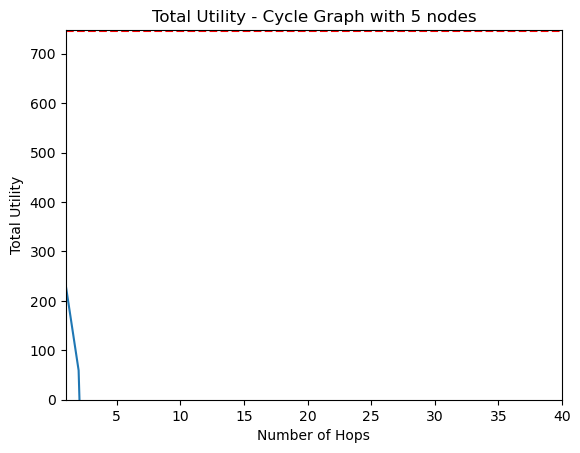

In [179]:
# plot the total utility as a function of the number of hops
plt.figure()
plt.plot(range(1, max_hops + 1), [total_utility(x_nash, q, sum_of_powers(G, i)) for i, x_nash in enumerate(x_nash_list1, 1)])
# plot socially optimal utility
plt.axhline(-soc_opt_result.fun, color='r', linestyle='--', label='Socially Optimal')
plt.xlim(1, max_hops)
plt.ylim(0, 1-soc_opt_result.fun)
plt.xlabel("Number of Hops")
plt.ylabel("Total Utility")
plt.title(f"Total Utility - Cycle Graph with {n} nodes")
plt.show()

In [185]:
opt_result = find_social_optimum(q, G, bounds)
print(f"Socially optimal solution: {opt_result.x}")
print(f"Maximum total utility: {-opt_result.fun}")

Socially optimal solution: [2.72966828e+152 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 4.43948808e+153 1.82426588e+152 0.00000000e+000
 0.00000000e+000 0.00000000e+000]
Maximum total utility: 0.0


/var/folders/hs/y116vr4j4yg5fcthw_l99c5r0000gn/T/ipykernel_24647/1821943446.py:21: RuntimeWarning: overflow encountered in double_scalars
  interaction_term = -np.sum([G[i, j] * x[i] * x[j] for j in range(len(x))])
/var/folders/hs/y116vr4j4yg5fcthw_l99c5r0000gn/T/ipykernel_24647/1821943446.py:18: RuntimeWarning: overflow encountered in double_scalars
  quadratic_term = -0.5 * x[i]**2
/var/folders/hs/y116vr4j4yg5fcthw_l99c5r0000gn/T/ipykernel_24647/1821943446.py:24: RuntimeWarning: invalid value encountered in double_scalars
  utility_i = linear_term + quadratic_term + interaction_term
/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [186]:
# print(G)
# print(q)

[[ 0.         -1.18313237 -0.52721296  0.14606783  1.26015791 -1.99266062
  -0.25935646  1.63487466 -1.0142894   0.00871036]
 [-1.18313237  0.         -0.28106337 -0.14973619  0.07736745 -0.05887046
   0.68563989 -1.40247267 -0.24135147 -0.23473803]
 [-0.52721296 -0.28106337  0.         -1.18861916 -2.44704112 -0.99692595
   0.86726722  1.48131238  0.74072635  0.28849837]
 [ 0.14606783 -0.14973619 -1.18861916  0.          1.75097237 -0.07443226
   0.8757915  -0.7693608   0.25941367  1.31769451]
 [ 1.26015791  0.07736745 -2.44704112  1.75097237  0.         -0.60655804
  -0.2282032   0.01606091 -0.28280689  0.29581159]
 [-1.99266062 -0.05887046 -0.99692595 -0.07443226 -0.60655804  0.
  -3.37476637 -1.02597534  0.82643489 -0.54559838]
 [-0.25935646  0.68563989  0.86726722  0.8757915  -0.2282032  -3.37476637
   0.         -0.76369136 -0.74637695  1.94529777]
 [ 1.63487466 -1.40247267  1.48131238 -0.7693608   0.01606091 -1.02597534
  -0.76369136  0.          0.4862684  -0.66779786]
 [-1.014